In [3]:
import yaml
import os

In [4]:
INPUT_YAML = "image_data/real_training_data/real_data_annotations.yaml"
examples = yaml.load(open(INPUT_YAML, 'rb').read())

In [5]:
len_examples = len(examples)
print("Loaded", len(examples), "examples")

Loaded 159 examples


In [6]:
import random
random.seed(8)
random .shuffle(examples)

for i in range(len(examples)):
    examples[i]['filename'] = os.path.abspath(os.path.join(os.path.dirname(INPUT_YAML), examples[i]['filename']))

In [7]:
train_len = int(len_examples * 0.7)

In [8]:
train_examples = examples[:train_len]
test_examples = examples[train_len:]

In [9]:
print("Still", len(train_examples) + len(test_examples), "examples")

Still 159 examples


In [14]:
def count_examples(examples):
    label_counter =  {"Green" : 0, "Red" : 0, "Yellow" : 0}
    for example in examples:
        for box in example['annotations']:
            label_counter[box['class']] += 1
    return label_counter

In [15]:
train_examples_label = count_examples(train_examples)
test_examples_label = count_examples(test_examples)

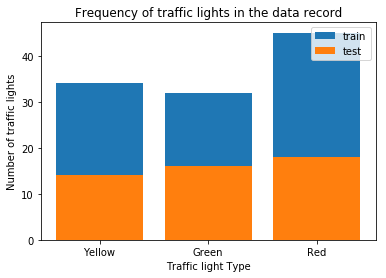

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel('Traffic light Type')
ax.set_ylabel('Number of traffic lights')
ax.set_title('Frequency of traffic lights in the data record')
plt.bar(list(train_examples_label.keys()), list(train_examples_label.values()), label='train')
plt.bar(list(test_examples_label.keys()), list(test_examples_label.values()), label='test')
plt.legend(loc='upper right')

In [17]:
import imgaug as ia
from imgaug import augmenters as iaa
import cv2

def augment_image(image, annotations, do_not_augment=False):   
    boundingBoxes = []
    for annotation in annotations:
        boundingBoxes.append(ia.BoundingBox(
                annotation['xmin'], annotation['ymin'],
                annotation['xmin'] + annotation['x_width'], annotation['ymin'] + annotation['y_height'],
                annotation['class']
            ))
    
    bbs = ia.BoundingBoxesOnImage(boundingBoxes, shape=image.shape)
    if do_not_augment:
        seq = iaa.Sequential()
    else:
        seq = iaa.Sequential([
            iaa.Fliplr(0.5), # horizontal flips
            iaa.Crop(percent=(0, 0.1)), # random crops
            # Small gaussian blur with random sigma between 0 and 0.5.
            # But we only blur about 50% of all images.
            iaa.Sometimes(0.5,
                iaa.GaussianBlur(sigma=(0, 0.5))
            ),
            # Strengthen or weaken the contrast in each image.
            iaa.ContrastNormalization((0.75, 1.5)),
            # Add gaussian noise.
            # For 50% of all images, we sample the noise once per pixel.
            # For the other 50% of all images, we sample the noise per pixel AND
            # channel. This can change the color (not only brightness) of the
            # pixels.
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
            # Make some images brighter and some darker.
            # In 20% of all cases, we sample the multiplier once per channel,
            # which can end up changing the color of the images.
            iaa.Multiply((0.8, 1.2), per_channel=0.2),
            # Apply affine transformations to each image.
            # Scale/zoom them, translate/move them, rotate them and shear them.
            iaa.Affine(
                scale={"x": (0.9, 1.2), "y": (0.9, 1.2)},
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate=(-5, 5),
                shear=(-8, 8)
            )
        ], random_order=True)
    
    seq_det = seq.to_deterministic()  # only once PER BATCH

    image_aug = seq_det.augment_images([image])[0]
    bbs_aug  = seq_det.augment_bounding_boxes([bbs])[0]
    
    all_bbs_valid = True
    for bb in bbs_aug.bounding_boxes:
        if not bb.is_fully_within_image(image.shape): # and not bb.is_partly_within_image(image.shape):
            all_bbs_valid = False
    
    if not all_bbs_valid:
        return augment_image(image, annotations) # caluclate new image as last one had invalid BoundingBoxes
    else:
        return image_aug, bbs_aug

In [18]:
test_example = train_examples[2]
image = cv2.cvtColor(cv2.imread(test_example['filename']), cv2.COLOR_BGR2RGB)
image_aug, bbs_aug = augment_image(image, test_example['annotations'])

BoundingBoxesOnImage([BoundingBox(x1=904.5620, y1=279.8078, x2=964.5331, y2=458.6926, label=Red)], shape=(1096, 1368, 3))


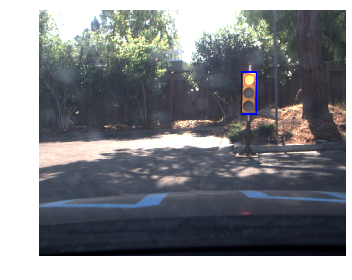

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

print(bbs_aug)
image_after = bbs_aug.draw_on_image(image_aug, thickness=8, color=[0, 0, 255])
plt.imshow(image_after)
plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
import tensorflow as tf
import dataset_util
from io import BytesIO
from PIL import Image

LABEL_DICT =  {"Green" : 1, "Red" : 2, "Yellow" : 3, "off" : 4}

def create_tf_example(example, num_new_data=1):
    tf_examples = []
    # Udacity sim data set
    height = 600 # Image height
    width = 800 # Image width

    filename = example['filename'] # Filename of the image. Empty if image is not from file
    image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    
    for idx in range(0, num_new_data):
        image_aug, bbs_aug = augment_image(image, example['annotations'], idx == 0)

        image_format = 'jpg' 

        xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
        xmaxs = [] # List of normalized right x coordinates in bounding box (1 per box)
        ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
        ymaxs = [] # List of normalized bottom y coordinates in bounding box (1 per box)
        classes_text = [] # List of string class name of bounding box (1 per box)
        classes = [] # List of integer class id of bounding box (1 per box)

        for box in bbs_aug.bounding_boxes:
            #if box['occluded'] is False:
            #print("adding box")
            xmins.append(float(box.x1 / width))
            xmaxs.append(float(box.x2 / width))
            ymins.append(float(box.y1 / height))
            ymaxs.append(float(box.y2 / height))
            classes_text.append(box.label.encode())
            classes.append(int(LABEL_DICT[box.label]))

        imgByteArr = BytesIO()
        img = Image.fromarray(image_aug)
        img.save(imgByteArr, 'JPEG')
        encoded_jpg = imgByteArr.getvalue()

        tf_example = tf.train.Example(features=tf.train.Features(feature={
            'image/height': dataset_util.int64_feature(height),
            'image/width': dataset_util.int64_feature(width),
            'image/filename': dataset_util.bytes_feature(filename.encode()),
            'image/source_id': dataset_util.bytes_feature(filename.encode()),
            'image/encoded': dataset_util.bytes_feature(encoded_jpg),
            'image/format': dataset_util.bytes_feature(image_format.encode()),
            'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
            'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
            'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
            'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
            'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
            'image/object/class/label': dataset_util.int64_list_feature(classes),
        }))
        tf_examples.append(tf_example)

    return tf_examples


In [22]:
train_examples_label

{'Green': 32, 'Red': 45, 'Yellow': 34}

In [23]:
train_factor = {}
train_factor['Red'] = 5
train_factor['Green'] = int(round(train_examples_label['Red'] / train_examples_label['Green'] * train_factor['Red']))
train_factor['Yellow'] = int(round(train_examples_label['Red'] / train_examples_label['Yellow'] * train_factor['Red']))

print(train_factor)

{'Yellow': 7, 'Green': 7, 'Red': 5}


In [24]:
def classes_in_image(annotations):
    classes = {'Green': 0, 'Red': 0, 'Yellow': 0}
    for annotation in annotations:
        classes[annotation['class']] += 1
    return classes    

In [25]:
for train_example in train_examples[:2]:
    classes = classes_in_image(train_example['annotations'])
    max_class = max(classes, key=classes.get)
    print(classes)
    print(max_class, classes[max_class])
    print()

{'Yellow': 0, 'Green': 1, 'Red': 0}
Green 1

{'Yellow': 1, 'Green': 0, 'Red': 0}
Yellow 1



In [27]:
from tqdm import tqdm_notebook as tqdm

train_aug_examples_label = {'Green': 0, 'Red': 0, 'Yellow': 0}

writer = tf.python_io.TFRecordWriter("real_train.record")
for train_example in tqdm(train_examples):
    classes = classes_in_image(train_example['annotations'])
    max_class = max(classes, key=classes.get)
    
    for class_name in ['Green', 'Yellow', 'Red']:
        train_aug_examples_label[class_name] += classes[class_name] * train_factor[class_name]
        
    tf_examples = create_tf_example(train_example, train_factor[max_class])
    for tf_example in tf_examples:
        writer.write(tf_example.SerializeToString())
writer.close()

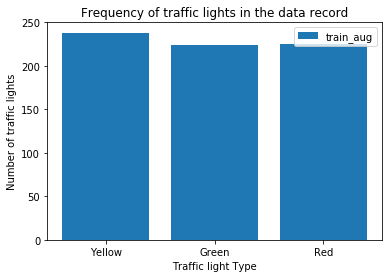

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel('Traffic light Type')
ax.set_ylabel('Number of traffic lights')
ax.set_title('Frequency of traffic lights in the data record')
plt.bar(list(train_aug_examples_label.keys()), list(train_aug_examples_label.values()), label='train_aug')
# plt.bar(list(test_examples_label.keys()), list(test_examples_label.values()), label='test')
plt.legend(loc='upper right')
plt.show()

In [29]:
test_factor = {}
test_factor['Red'] = 5
test_factor['Green'] = int(round(test_examples_label['Red'] / test_examples_label['Green'] * test_factor['Red']))
test_factor['Yellow'] = int(round(test_examples_label['Red'] / test_examples_label['Yellow'] * test_factor['Red']))

print(test_factor)

{'Yellow': 6, 'Green': 6, 'Red': 5}


In [30]:
from tqdm import tqdm_notebook as tqdm

test_aug_examples_label = {'Green': 0, 'Red': 0, 'Yellow': 0}

writer = tf.python_io.TFRecordWriter("real_test.record")
for test_example in tqdm(test_examples):
    classes = classes_in_image(test_example['annotations'])
    max_class = max(classes, key=classes.get)
    
    for class_name in ['Green', 'Yellow', 'Red']:
        test_aug_examples_label[class_name] += classes[class_name] * test_factor[class_name]
        
    tf_examples = create_tf_example(test_example, test_factor[max_class])
    for tf_example in tf_examples:
        writer.write(tf_example.SerializeToString())
writer.close()

In [31]:
print(train_aug_examples_label)
print(test_aug_examples_label)

{'Yellow': 238, 'Green': 224, 'Red': 225}
{'Yellow': 84, 'Green': 96, 'Red': 90}


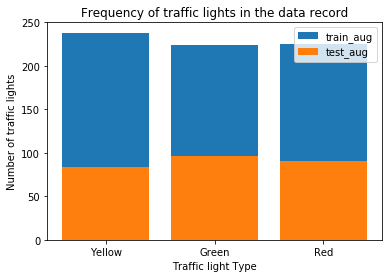

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel('Traffic light Type')
ax.set_ylabel('Number of traffic lights')
ax.set_title('Frequency of traffic lights in the data record')
plt.bar(list(train_aug_examples_label.keys()), list(train_aug_examples_label.values()), label='train_aug')
plt.bar(list(test_aug_examples_label.keys()), list(test_aug_examples_label.values()), label='test_aug')
plt.legend(loc='upper right')
plt.show()